In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import palettable
import warnings
warnings.filterwarnings('ignore')
import pickle

In [2]:
# read data
df = pd.read_csv('heart_2020_cleaned.csv')
df.head(5) 

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


Note that the original data format is a survey, therefore most of the column variables have boolean responses. Here are detailed explainations for the features:

1. **HeartDisease:** Whether the respondent has reported having coronary heart disease (CHD)/myocardial infarction (MI)  
2. **BMI:** Body Mass Index  
3. **Smoking:** Whether the respondent has smoked more than 100 cigarettes so far  
4. **AlcoholDrinking:** Whether the male respondent has 14 drinks per week/Whether the female respondent has 7 drinks per week  
5. **Stroke:** Whether the respondent have ever had a stroke  
6. **PhysicalHealth:** Number of days that’s considered ‘not having good physical health’ by the respondent during the past 30 days  
7. **MentalHealth:** Number of days that’s considered ‘not having good mental health’ by the respondent during the past 30 days  
8. **DiffWalking:** Whether the respondent has serious difficulty walking or climbing stairs  
9. **Sex:** Gender of the respondent  
10. **AgeCategory:** The respondent should choose from ‘18-24’, ‘25-29’, ‘30-34’, ‘35-39’, ‘40-44’, ‘45-49’, ‘50-54’, ‘55-59’, ‘60-64’, ‘65-69’, ‘70-74’, ‘75-79’, ‘80 or older’  
11. **Race:** The respondent should choose from 'White', 'Black', 'Asian', 'American Indian/Alaskan Native', ‘Hispanic’, 'Other'  
12. **Diabetic:** The respondent should choose from ‘Yes', ‘No'', 'No, borderline diabetes', 'Yes (during pregnancy)’  
13. **PhysicalActivity:** Whether the respondent did any physical activity or exercise during the past 30 days other than his or her regular jobs  
14. **GenHealth:** The respondent should evaluate his or her own health and choose from ‘Poor', ‘Fair', ‘Good', 'Very good’, ‘Excellent'  
15. **SleepTime:** Number of hours that the respondent gets in a 24-hour period on average  
16. **Asthma:** Whether the respondent had asthma  
17. **KidneyDisease:** Whether the respondent have had kidney disease except kidney stones, bladder infection, or incontinence  
18. **SkinCancer:** Whether the respondent have had skin cancer  

Basically there are two types of features, numerical and categorical. More specifically, BMI is a continuous numerical feature; PhysicalHealth, MentalHealth, and SleepTime are discrete numerical features. Likewise, HeartDisease, Sex, Smoking, Stroke, Asthma, AlcoholDrinking, KidneyDisease, SkinCancer, PhysicalActivity, and DiffWalking are binary categorical features; AgeCategory and GenHealth are ordinal categorical features; Race and Diabetic are nominal categorical features.

## 1. Dependent Variable

From the original dataset with 319,795 records, the number of respondents with heart disease is 27,273, while that of respondents without heart disease is 292,522. Respondents with heart disease account for about 8% in the overall.

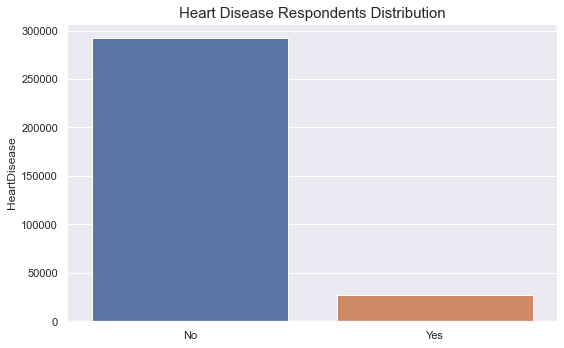

In [3]:
# create barchart for dependent variable
plt.figure(figsize=(8,5))
sns.barplot(x=df.HeartDisease.unique(), y=df.HeartDisease.value_counts(), data=df)
plt.title('Heart Disease Respondents Distribution', fontsize=15)
plt.tight_layout()
plt.show()

From the observation above, the distribution of dependent variable is highly imbalanced. The data discrimination may cause potential problems such as biased prediction which leads to a high accuracy but a relatively low AUC. Thus, for the purpose of building better models, I undersampled the data points for people who do not have a heart disease.

In [4]:
# undersample data points
df_yes = df[df['HeartDisease'] == 'Yes']
df_no = df[df['HeartDisease'] == 'No']
count_no, count_yes = df['HeartDisease'].value_counts()
df_no_under = df_no.sample(count_yes)
df_under = pd.concat([df_no_under, df_yes], axis=0)
df = df_under

After undersampling, we managed to get a balanced dataset. In the adjusted dataset with 54,546 records, the number of respondents with or without heart disease is both 27,373. Respondents with heart disease account for 50% in the overall.

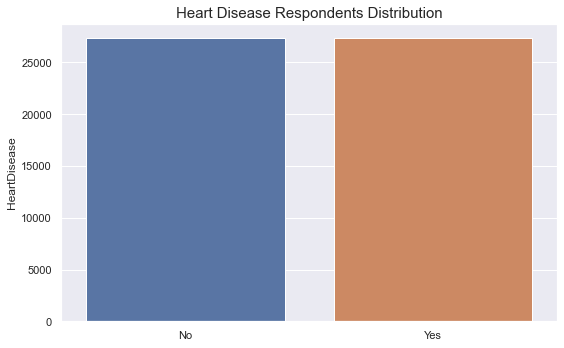

In [7]:
# create barchart for adjusted dependent variable
plt.figure(figsize=(8,5))
sns.barplot(x=df.HeartDisease.unique(), y=df.HeartDisease.value_counts(), data=df)
plt.xticks([0,1], labels=['No','Yes'])
plt.title('Heart Disease Respondents Distribution', fontsize=15)
plt.tight_layout()
plt.show()

## 2. Numerical Features

For numerical features, the boxplots are used for exploration. It is easy to see that the distributions of physical health between adults with and without heart disease are dramatically different, whereas the distribution differences in BMI, sleep time and mental health are subtle. Therefore, further work are needed in terms of evaluating the relationship of heart disease and these numerical features.

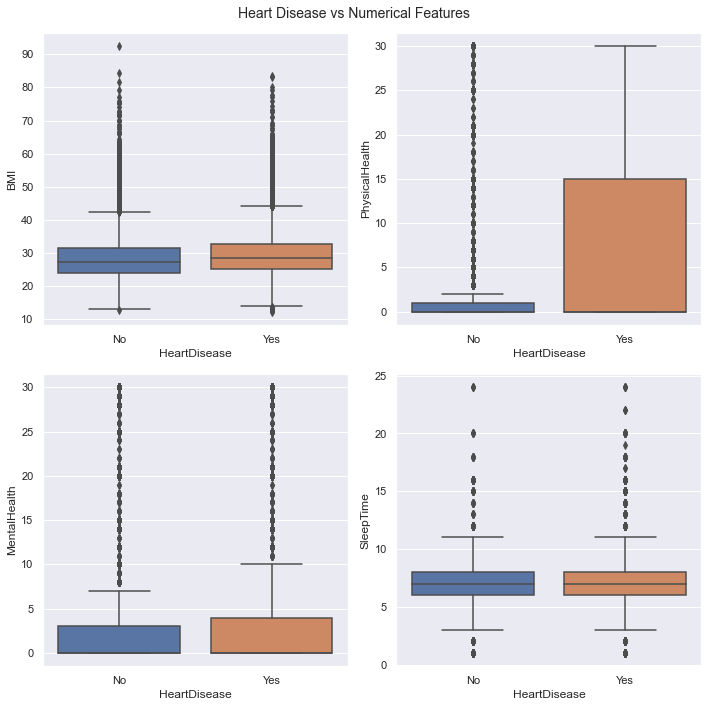

In [8]:
# create boxplots for heart disease and numerical features
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Heart Disease vs Numerical Features', fontsize=14)
sns.boxplot(ax=axes[0, 0], data=df, x='HeartDisease', y='BMI')
sns.boxplot(ax=axes[0, 1], data=df, x='HeartDisease', y='PhysicalHealth')
sns.boxplot(ax=axes[1, 0], data=df, x='HeartDisease', y='MentalHealth')
sns.boxplot(ax=axes[1, 1], data=df, x='HeartDisease', y='SleepTime')
plt.tight_layout()
plt.show()

## 3. Categorical Features

In order to evaluate the relationship of heart disease and categorical features, here I used the correlation analysis. I mainly utilized piecharts which could convey information needed. Below I created a function to draw piecharts of heart disease and categorical features.

In [10]:
# create a function to draw piecharts of heart disease and categorical features
def draw_pie(c, f, t, n):
    fig, axes = plt.subplots(1, 2, figsize=(n,n))
    y = df[df["HeartDisease"]=='Yes'][f].value_counts()
    n = df[df["HeartDisease"]=='No'][f].value_counts()
    y.plot.pie(autopct='%.1f%%', ax=axes[0], colors=[c[i] for i in y.keys()])                                                                     
    n.plot.pie(autopct='%.1f%%', ax=axes[1], colors=[c[i] for i in n.keys()])
    axes[0].set_title(t+'With heart disease', fontsize=13)
    axes[1].set_title(t+'Without heart disease', fontsize=13)
    plt.tight_layout()
    plt.show()

First, I looked into ordinal categorical features: AgeCategory and GenHealth. The strong positive correlation between age-increasing and heart disease is easy to spot. Furthremore, those who have heart disease tend to rate themselves as unhealthier.

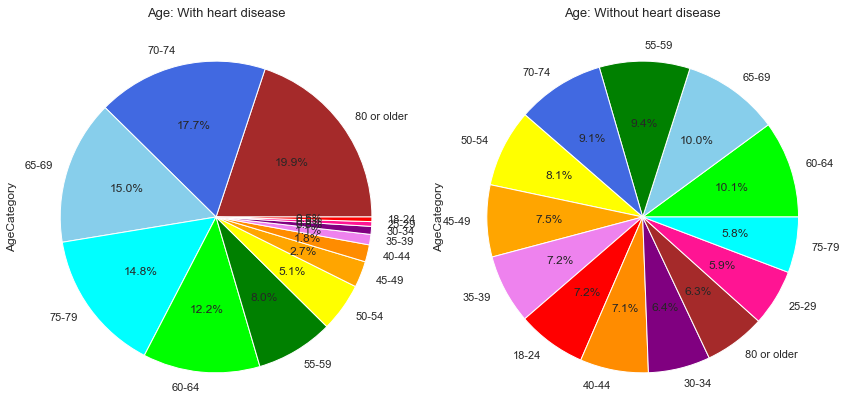

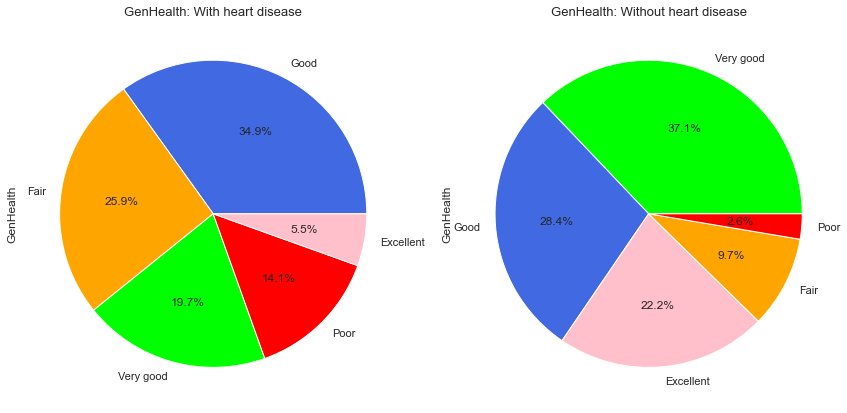

In [11]:
# draw piecharts of heart disease and ordinal categorical features
c_age = {'18-24':'red','25-29':'deeppink','30-34':'purple','35-39':'violet','40-44':'darkorange', 
         '45-49':'orange','50-54':'yellow','55-59':'green','60-64':'lime','65-69':'skyblue', 
         '70-74':'royalblue','75-79':'cyan','80 or older':'brown'}
c_gen = {'Poor':'red','Fair':'orange','Good':'royalblue','Very good':'lime','Excellent':'pink'}
draw_pie(c_age, 'AgeCategory', 'Age: ', 12)
draw_pie(c_gen, 'GenHealth', 'GenHealth: ', 12)

Second, as for nominal categorical features, I might be able to conclude that Asian, Black and Hispanic respondents have a lower probability of getting heart disease than other races. However, further analysis is necessary to confirm this statement. In addition, sample populations with diabetes are much more likely to have heart disease than those without.

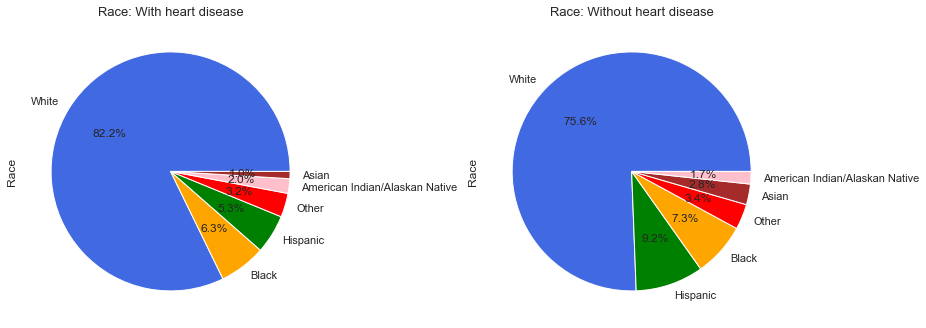

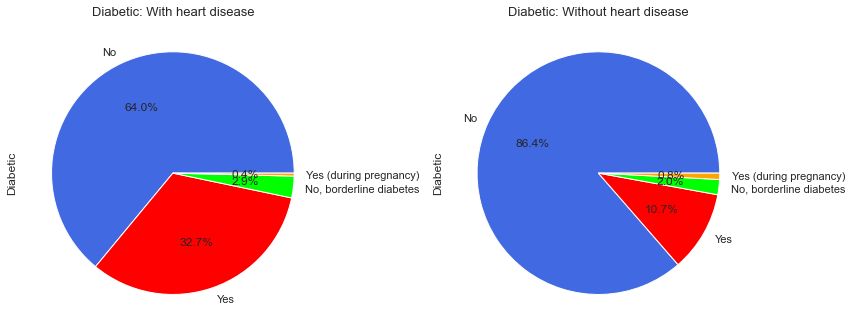

In [12]:
# draw piecharts of heart disease and nominal categorical features
c_race = {'White':'royalblue', 'Black':'orange', 'Asian':'brown', 'American Indian/Alaskan Native':'pink',
          'Other':'red', 'Hispanic':'green'}
c_dia = {'Yes':'red', 'No':'royalblue', 'No, borderline diabetes':'lime', 'Yes (during pregnancy)':'orange'}
draw_pie(c_race, 'Race', 'Race: ', 13)
draw_pie(c_dia, 'Diabetic', 'Diabetic: ', 12)

Third, for binary categorical features, piecharts are also used for evaluation. After grouping by each feature, from an overall perspective, I could see that the proportion of men having heart disease is significantly larger than women by 18%. Also, among the sample population with heart disease, the percentage of smokers is higher than non-smokers by 17.2%.

However, when it comes to alcohol drinking, the difference between sample population with and without heart disease is little. But then again, people with stroke experiences are much more likely to have heart disease rather than people who do not, and the difference in proportion is 13.4%. Like alcohol drinking, asthma also has little to do with the heart disease distribution, since the difference is only 5.2%. Nevertheless, having serious difficulty walking or climbing stairs could be one of the key features of having heart disease, and the between-group difference is as high as 24.6%.

Finally, the proportions of sample populations with and without heart disease are noticeably different in physical activity, kidney disease as well as skin cancer; and the differences are 15.2%, 9.8% and 10.0% respectively.

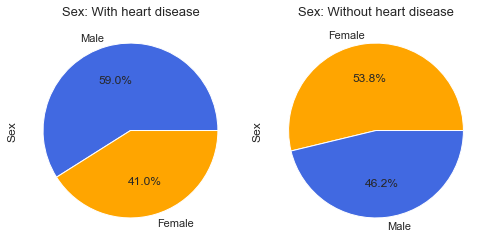

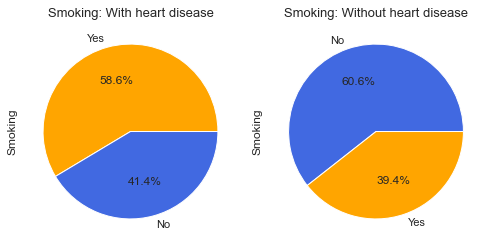

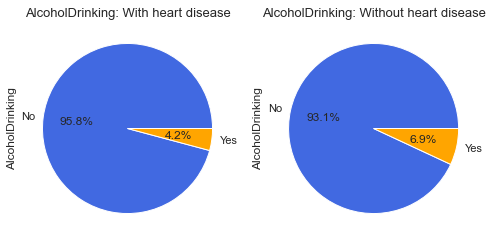

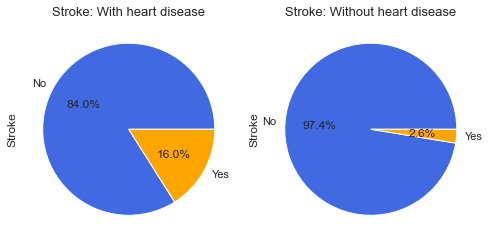

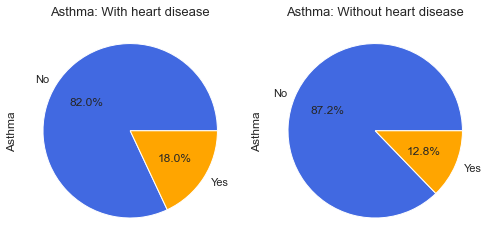

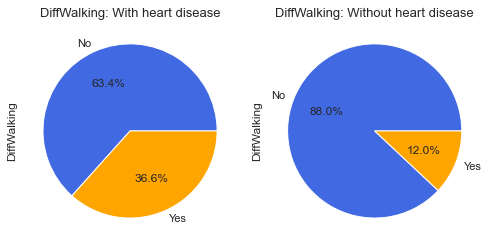

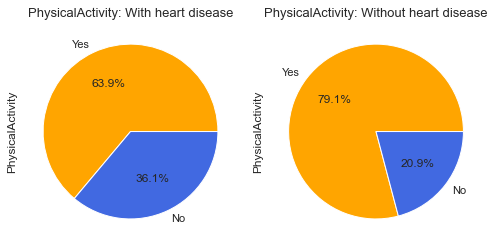

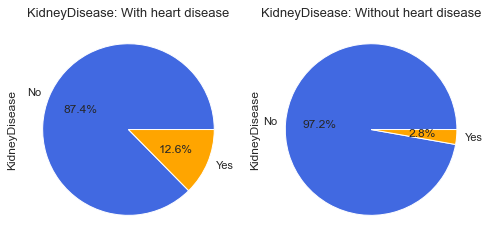

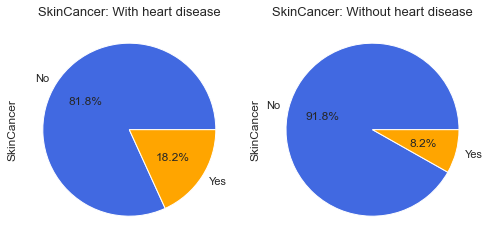

In [13]:
# create piecharts for heart disease and binary categorical features
c_sex = {'Male':'royalblue','Female':'orange'}
c_bi = {'Yes':'orange','No':'royalblue'}
bi = ['Smoking',
      'AlcoholDrinking',
      'Stroke',
      'Asthma', 
      'DiffWalking',
      'PhysicalActivity',
      'KidneyDisease',
      'SkinCancer']
draw_pie(c_sex, 'Sex','Sex: ', 7)
for i in bi:
    draw_pie(c_bi, i, i+': ', 7)